In [7]:
import networkx as nx
import math
import itertools
%pylab inline
from sklearn.metrics import pairwise_distances
import sys

Populating the interactive namespace from numpy and matplotlib


In [8]:
sys.path.append("../CODE") # add code folder
from NNO_util_minh import *

In [10]:
f=open('dolphins.txt','r')
print(f.read())
f1=open('dolphins.gml','r')
#print(f1.read())

The file dolphins.gml contains an undirected social network of frequent
associations between 62 dolphins in a community living off Doubtful Sound,
New Zealand, as compiled by Lusseau et al. (2003).  Please cite

  D. Lusseau, K. Schneider, O. J. Boisseau, P. Haase, E. Slooten, and
  S. M. Dawson, The bottlenose dolphin community of Doubtful Sound features
  a large proportion of long-lasting associations, Behavioral Ecology and
  Sociobiology 54, 396-405 (2003).

Additional information on the network can be found in

  D. Lusseau, The emergent properties of a dolphin social network,
  Proc. R. Soc. London B (suppl.) 270, S186-S188 (2003).

  D. Lusseau, Evidence for social role in a dolphin social network,
  Preprint q-bio/0607048 (http://arxiv.org/abs/q-bio.PE/0607048)



In [11]:
my_graph = nx.Graph()
gml_graph = nx.read_gml('./dolphins.gml')
pos=nx.spring_layout(gml_graph)
#nx.draw(gml_graph, with_labels=True, font_weight='bold')
#plt.savefig('Dolphins.pdf')
#plt.show()

In [12]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=measures.values(),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()


In [13]:
def run_pagerank_save_iterations(x0,T,Al,N):
    x=x0.copy()
    previous_r = x
    X = np.zeros((T,N))
    for i in range(0,T):
        X[i,:] = x
        x = x*Al
        x = x/sum(x)
        
    return X

def compute_Bottleneck_kNN(T,X):
    bottle_distances_kNN = zeros(T)
    nodes=rowvect2D(X[-1])
    FINAL_neighbor_order_matrix = neighbor_ordering(nodes,'max')
    FINAL_diag_kNN=dist2PD(FINAL_neighbor_order_matrix,1,13)[1]
    for t in range(T):
        nodes=rowvect2D(X[t])
        neighbor_order_matrix = neighbor_ordering(nodes,'max')
        diag_kNN=dist2PD(neighbor_order_matrix,1,13)[1]
        bottle_distances_kNN[t] = bottleneck(diag_kNN,FINAL_diag_kNN)[0]
        bottle_distances_kNN[t] = bottle_distances_kNN[t] * (bottle_distances_kNN[t]>10**(-16))
    return bottle_distances_kNN

def compute_Bottleneck_kNN_min(T,X):
    bottle_distances_kNN_min = zeros(T)
    nodes=rowvect2D(X[-1])
    FINAL_neighbor_order_matrix_min = neighbor_ordering(nodes,'min')
    FINAL_diag_kNN_min=dist2PD(FINAL_neighbor_order_matrix_min,1,13)[1]
    for t in range(T):
        nodes=rowvect2D(X[t])
        neighbor_order_matrix_min = neighbor_ordering(nodes,'min')
        diag_kNN_min=dist2PD(neighbor_order_matrix_min,1,13)[1]
        bottle_distances_kNN_min[t] = bottleneck(diag_kNN_min,FINAL_diag_kNN_min)[0]
        bottle_distances_kNN_min[t] = bottle_distances_kNN_min[t] * (bottle_distances_kNN_min[t]>10**(-16))
    return bottle_distances_kNN_min

def compute_Bottleneck_VR(T,X):
    bottle_distances_VR = zeros(T)
    nodesf=rowvect2D(X[-1])
    dnf=dists(nodesf,nodesf)
    FINAL_diag_VR=dist2PD(dnf,2,1)[1]
    for t in range(T):
        nodes=rowvect2D(X[t])
        dn=dists(nodes,nodes)    
        diag_VR=dist2PD(dn,2,1)[1]
        bottle_distances_VR[t] = bottleneck(diag_VR,FINAL_diag_VR)[0]
    return bottle_distances_VR

def ranks(X):
    ranks = zeros(shape(X))
    for t in range(len(X)):
        ranks[t] = argsort(-X[t])
    return ranks

def diff(X):
    diff_X = array([ norm(Xt - X[-1]) for Xt in X ])
    r = ranks(X)
    diff_ranks = np.sum( abs(r-r[-1]) > 0 ,1 )    
    return diff_X,diff_ranks


# Study impact of teleportation parameter on kNN homology convergence for Dolphins network

In [14]:
def run_PR_alpha(graph,alpha=.85,T=80):    
    Al = nx.google_matrix(graph, alpha, personalization=None, nodelist=None, weight='weight', dangling=None)
    N=len(Al)
    x0 = linspace(2,3,N) 
    x0 = x0.T/sum(x0)
    X=run_pagerank_save_iterations(x0,T,Al,N)
    return X

In [15]:
#alphas = [.55,.75,.95]
alphas = [.5,.65,.8,.95]


alpha =  0.5
alpha =  0.65
alpha =  0.8
alpha =  0.95


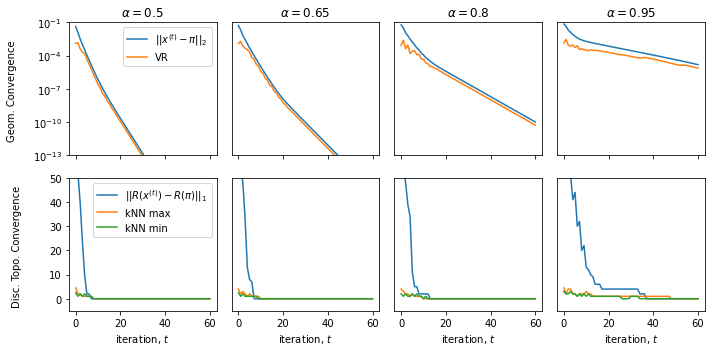

In [16]:
its = arange(61)
T=80 


f1,ax = plt.subplots(2,len(alphas),figsize=(10,5),sharex=True)

for i,alpha in enumerate(alphas):
    print('alpha = ',alpha)
    
    X = run_PR_alpha(gml_graph,alpha,T)

    diffs = diff(X)
    ax[0,i].semilogy(diffs[0][its])
    ax[0,i].semilogy(compute_Bottleneck_VR(T,X)[its])
    ax[0,i].set_ylim(10**-13,10**-1)
    #ax[0,i].set_title(r'Geometrical Convergence ($\alpha='+str(alpha)+'$)' )
    
    ax[0,i].set_title(r'$\alpha='+str(alpha)+'$' )
    
    ax[1,i].plot(diffs[1][its])
    ax[1,i].plot((compute_Bottleneck_kNN(T,X)[its][its]))
    ax[1,i].plot((compute_Bottleneck_kNN_min(T,X)[its]))

    ax[1,i].set_xlabel(r'iteration, $t$')
    ax[1,i].set_ylim(-5,50)

    if i>0:
        ax[0,i].set_yticks([])
        ax[1,i].set_yticks([])

    
ax[0,0].legend([r'$||x^{(t)} -\pi||_2$','VR'],loc='upper right')
ax[1,0].legend([r'$||R(x^{(t)}) -R(\pi)||_1$','kNN max', 'kNN min'],loc='upper right')
ax[0,0].set_ylabel('Geom. Convergence \n')
ax[1,0].set_ylabel('Disc. Topo. Convergence \n\n')
    
plt.tight_layout()
plt.savefig('Dolphins_convergence_parameters.pdf')
